# Deep Learning with Python - Chapter 3

## Example 2 - Reuters Newswire Multiclass Classification

In the previous example, we used an ANN to classify movie reviews from the IMDb dataset as either positive or negative. This was a binary classification problem - we were predicting the category of a label for a given sample, where each label could be one of two values.

**Mulitclass classification** problems are those where there are more than two labels/categories of the output variable. Each sample in the dataset is a Reuters newswire (digital message transmitting breaking news) that can belong to one of 46 mutually exclusive classes. So this is specifically a **single-label, multiclass classification** problem.

## Setup and Exploratory Data Analysis

In [2]:
# Importing libraries
import tensorflow as tf      # backend
import keras  

# Configure numpy to enable data read from built-in dataset (pickle file)
import numpy as np
old = np.load
np.load = lambda *a,**k: old(*a, allow_pickle=True, **k)

In [3]:
# Import the reuters dataset
from keras.datasets import reuters

In [5]:
# Train/test split - limiting ourselves to 10k most frequently occurring words in news headlines
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 3s 2us/step


In [9]:
# Examine length of training and test data to identify train/test ratio
print("Training Samples:\t" + str(len(train_data)))
print("Test Samples:\t\t" + str(len(test_data)))

Training Samples:	8982
Test Samples:		2246


In [11]:
# As with IMDb, each entry in dataset is a list of integers that encode a word
print(train_data[10][:20])     # first 20 words in the 11th headline

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689]


In [13]:
# Just like IMDb, can decode each headline by looking up the word corresponding to the word index

# Built-in dictionary mapping words to index numbers
word_index = reuters.get_word_index()

# Creating our own dictionary where the index number is the key - helps decode messages through dict lookup
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Again, first three indexes were reserved for <START>, <STOP>, <UNK> and have been removed - index shift by 3
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [14]:
# The training and test labels are numbers corresponding to 1 of 46 categories
print(train_labels[0])

3


## Preparing the Data

In [15]:
# Must vectorize the samples before they can be fed into a NN
def vectorize_sequences(sequences, dimension=10000):
    # create empty matrix with one row per newsline and one column per 10k frequently occurring word
    results = np.zeros((len(sequences), dimension))

    # for every newsline in the list of sequences passed as argument
    for i, sequence in enumerate(sequences):
        # find the column number corresponding to the current word index, and set it to 1 - one-hot encoding
        results[i, sequence] = 1.0    # numpy float, not integer!
        
    # at the end, return the one-hot encoded sequence of newslines
    return results

In [16]:
# Apply this function to both training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [18]:
# One-hot encoding the labels - so labels will become 46 dimensional vectors
def to_one_hot(labels, dimension=46):
    # Same as before - create a matrix with one row per training sample and one column per category
    results = np.zeros((len(labels), dimension))
    
    # for the current training sample, find the column with the same number as the category and set to 1
    for i, label in enumerate(labels):
        results[i, label] = 1.    # numpy float, not integer!
    
    # return the one-hot encoded vector
    return results

In [19]:
# Now apply this function to both training and test labels
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [21]:
# We can also do this using the built-in `to_categorical` function
from keras.utils.np_utils import to_categorical

one_hot_train_cat = to_categorical(train_labels)
one_hot_test_cat = to_categorical(test_labels)

## Building the Network
In the previous example, we used 16 nodes per layer since it was a simple binary classification problem and a 16-dimensional hypothesis space is sufficiently large for the ANN to learn how to separate two classes. However, with 46 classes, a 16 dimensional hypothesis space may be too limited. If any relevant information is lost by a 16-dimensional layer earlier on in the ANN flow, it cannot be recovered by a higher-dimensional space later in the ANN. Thus, to avoid such **information bottlenecks**, we will use 64 nodes per layer.

In [24]:
# Import
from keras import models, layers

# Instantiate
model = models.Sequential()

# Define node counts for input/hidden and output layer
n_nodes = 64
n_classes = 46

# Add layers
model.add(layers.Dense(n_nodes, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(n_nodes, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

The best loss function for a multiclass classification problem is `categorical_crossentropy`. The output for a multiclass classification problem is an `n_classes` dimensional vector, where each element represents the computed probability that a given training sample belongs to a specific class. This forms a predicted probability distribution, which is compared with the actual probability distribution by the categorical crossentropy function. This function aims to minimise the difference between predicted and actual probability distributions.

In [26]:
# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Create partial training and validation sets
# Number of samples to be used in the validation set
n_val = 1000

# Validation set
x_val = x_train[:n_val]; 
y_val = one_hot_train_labels[:n_val]

# Training set redefined
partial_x_train = x_train[n_val:]
partial_y_train = one_hot_train_labels[n_val:]

In [32]:
# Training the model for 20 epochs
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 206us/step - loss: 2.5530 - acc: 0.5247 - val_loss: 1.7379 - val_acc: 0.6360
Epoch 2/20
7982/7982 [==============================] - 1s 131us/step - loss: 1.4267 - acc: 0.7097 - val_loss: 1.3155 - val_acc: 0.7190
Epoch 3/20
7982/7982 [==============================] - 1s 132us/step - loss: 1.0576 - acc: 0.7808 - val_loss: 1.1512 - val_acc: 0.7500
Epoch 4/20
7982/7982 [==============================] - 1s 140us/step - loss: 0.8310 - acc: 0.8256 - val_loss: 1.0604 - val_acc: 0.7630
Epoch 5/20
7982/7982 [==============================] - 1s 137us/step - loss: 0.6620 - acc: 0.8624 - val_loss: 0.9798 - val_acc: 0.7860
Epoch 6/20
7982/7982 [==============================] - 1s 146us/step - loss: 0.5284 - acc: 0.8906 - val_loss: 0.9430 - val_acc: 0.7900
Epoch 7/20
7982/7982 [==============================] - 1s 157us/step - loss: 0.4268 - acc: 0.9094 - val_loss: 0.9380 - val_acc: 0.7990


In [71]:
# First import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Function that will take a history object to plot accuracy or loss data
def plot_hist_data(model_history, acc_flag=True):
    epochs = range(1, len(model_history.history['loss']) + 1)    # independent variable - epochs not zero-indexed
    title_str = 'Reuters Multiclass Classification'
    
    # Create a figure
    plt.figure(figsize=(6, 4));
    
    if (acc_flag==False):
        plt.plot(epochs, model_history.history['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, model_history.history['val_loss'], 'r-', label='Validation Loss')
        plt.ylabel('Loss - Categorical Crossentropy');
        title_str += ' - Loss'
    
    else:
        plt.plot(epochs, model_history.history['acc'], 'b-', label='Training Accuracy')
        plt.plot(epochs, model_history.history['val_acc'], 'r-', label='Validation Accuracy')
        plt.ylabel('Accuracy - Categorical Crossentropy');
        title_str += ' - Loss'
            
    # Regardless of plot target
    plt.title(title_str); plt.grid(True); plt.legend(); plt.tight_layout(); plt.xlabel('Epochs'); 

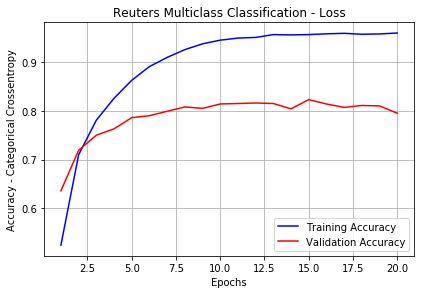

In [56]:
# Plotting the accuracy
plot_loss_data(history, True)

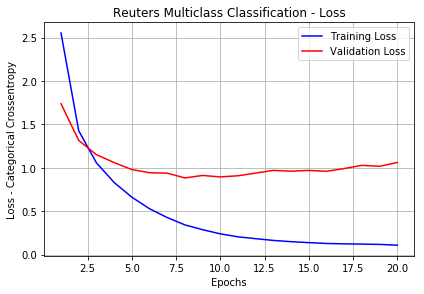

In [57]:
# Plotting the Loss
plot_hist_data(history, False)

## Training New Network - 9 Epochs
Since the model seems to overfit after 9 epochs, we can train the model for fewer epochs.

In [63]:
def create_model(n_nodes, n_classes):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(n_nodes, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    return model

model_2 = create_model(64, 46)
model_2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_2_hist = model_2.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val), verbose=0)

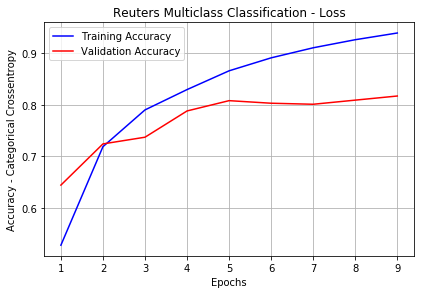

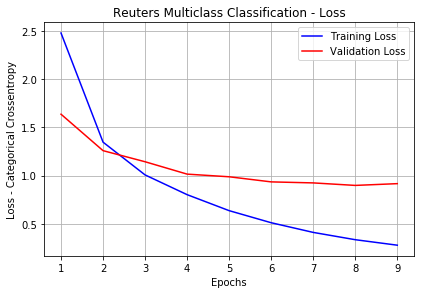

In [73]:
# Plotting the results of the second model with 9 epochs 
plot_hist_data(model_2_hist, acc_flag=True)
plot_hist_data(model_2_hist, acc_flag=False)

In [76]:
# Evaluating this new model on the test set
model_2_results = model_2.evaluate(x_test, one_hot_test_labels)
model_2_results

2246/2246 [==============================] - 0s 107us/step


[0.9800184424817296, 0.7827248441939468]

The results show that the test set prediction accuracy for the model with 9 epochs approaches 80%. This may not seem like much, but the benchmark against which this can be compared is a purely random classifier for multiclass classification, which has an accuracy of 19%. So a 78% accuracy is still a remarkable improvement.

In [79]:
# Testing a random multiclass classifier
import copy                                         # module to help us make shallow copies of numpy arrays
test_labels_copy = copy.copy(test_labels)           # copy the test set labels so that they aren't modified in random testing
np.random.shuffle(test_labels_copy)                 # a random multiclass classifier will produce this a randomly shuffled version of labels as OP

# Stores the number of times the random test labels will be the same as the actual test labels
hits_array = np.array(test_labels) == np.array(test_labels_copy)

# The accuracy is total correct predicted labels/total labels - 19%
float(np.sum(hits_array)) / len(test_labels)

0.19056099732858414

## Predictions on New Data

In [85]:
# This will store a 46 dimensional vector predicting probabilities for each class of news headline
predictions = model.predict(x_test)

# Confirm this by examining shape of first prediction
print(predictions[0].shape)

# But the sum of all the probabilities in the vector will be 1 - softmax
print(sum(predictions[0])) # Slightly above 1 because floating point inaccuracy

# Predicted class - the column with the largest probability
print(np.argmax(predictions[0]))

(46,)
1.0000000210494076
3


## ANN with Information Bottleneck
Creating and testing a new neural network with only 4 nodes in the hidden layer. This will serve as an information bottleneck and will prevent our neural network from the higher-dimensional transformations required to make accurate predictions. Expect accuracy to suffer. 

In [90]:
model_3 = models.Sequential()
model_3.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_3.add(layers.Dense(4, activation='relu'))
model_3.add(layers.Dense(46, activation='softmax'))
model_3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model_3_hist = model_3.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, 
                           validation_data=(x_val, y_val), verbose=0)

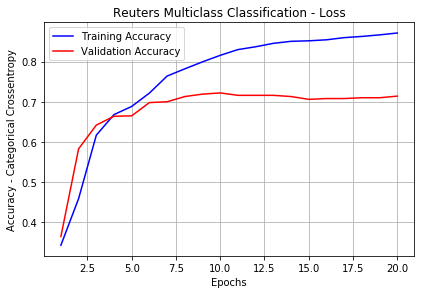

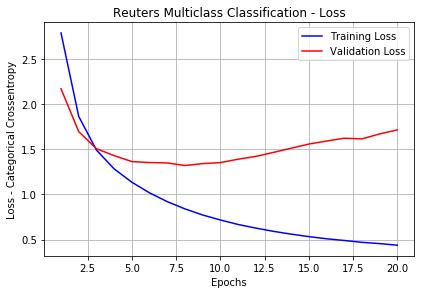

In [91]:
# Plotting the results of the new model
plot_hist_data(model_3_hist, acc_flag=True)    # Clear decrease in accuracy
plot_hist_data(model_3_hist, acc_flag=False)

The validation set accuracy as dropped from 